<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/florivz/DDM-Project-WS24-25.git

Cloning into 'DDM-Project-WS24-25'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 22), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 32.63 MiB | 18.46 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [3]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import userdata
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

# Loading the Data

In [4]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [5]:
gdp_data = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")
df_state = pd.read_pickle(pkl_path + 'state.pickle')

# Cleaning the data

In [6]:
# def add_zeros(code):
#     if len(code) == 3:
#         return '00' + code
#     elif len(code) == 4:
#         return '0' + code
#     elif len(code) == 1:
#         return '0000' + code
#     return code

In [7]:
# Filling 0 to get same length for all FIPS
# df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
# unique_lengths = df_pattern['FIPS'].apply(len).unique()
# unique_lengths

# df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [8]:
# Merging Occupation Datasets
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head(5)

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


In [9]:
# Imputing missing GDP data based on the average of adjacent years
# columns_to_impute = ['2017', '2018', '2019', '2020', '2021', '2022']

# def impute_missing_data(row):
#     for col in columns_to_impute:
#         if pd.isna(row[col]):
#             adjacent_years = [c for c in columns_to_impute if c != col]
#             values = [row[y] for y in adjacent_years if not pd.isna(row[y])]
#             row[col] = np.mean(values) if values else np.nan
#     return row

# gdp_data = gdp_data.apply(impute_missing_data, axis=1)

In [10]:
# Calculating GDP growth rate
gdp_data['GDP_growth_rate'] = (gdp_data['2022'] / gdp_data['2021']) * 100
gdp_data = gdp_data[(gdp_data != 0.0).all(axis=1)]
gdp_data = gdp_data.sort_values(by='GDP_growth_rate', ascending=False)
gdp_data.head()

,FIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019,2020,2021,2022,GDP_growth_rate
14594,13053,"Chattahoochee, GA",5,CAGDP9,25,"311-316,322-326",Nondurable goods manufacturing,Thousands of chained 2017 dollars,117.0,76.0,601.0,856.0,18.0,2001.0,11116.666667
92857,48319,"Mason, TX",6,CAGDP9,6,21,"Mining, quarrying, and oil and gas extraction",Thousands of chained 2017 dollars,15741.0,11470.0,6203.0,192.0,7.0,318.0,4542.857143
83439,46093,"Meade, SD",4,CAGDP9,6,21,"Mining, quarrying, and oil and gas extraction",Thousands of chained 2017 dollars,191.0,151.0,118.0,212.0,3.0,114.0,3800.000000
16866,13187,"Lumpkin, GA",5,CAGDP9,3,11,"Agriculture, forestry, fishing and hunting",Thousands of chained 2017 dollars,6249.0,3704.0,596.0,697.0,621.0,15307.0,2464.895330
18974,13313,"Whitfield, GA",5,CAGDP9,3,11,"Agriculture, forestry, fishing and hunting",Thousands of chained 2017 dollars,36393.0,35672.0,9588.0,2785.0,2936.0,69144.0,2355.040872


In [11]:
# Keeping only the necessary columns

# GDP
df_gdp_filtered = gdp_data.drop(gdp_data[['TableName', 'LineCode', 'Unit', 'Region', '2017', '2018', '2019', '2020', '2021', 'GeoName', 'IndustryClassification', 'Description']], axis=1)
df_gdp_filtered = df_gdp_filtered.rename(columns={'2022': 'current_gdp'})

df_gdp_filtered['FIPS'] = df_gdp_filtered['FIPS'].astype(str)
df_gdp_filtered = df_gdp_filtered[df_gdp_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers --> need it on county level

# Naics Pattern
df_pattern_filtered = df_pattern.drop(columns=['emp_nf', 'qp1_nf', 'qp1', 'ap_nf',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4', 'naics_2', 'State_GEOID',	'County_GEOID'])
df_pattern_filtered = df_pattern_filtered.rename(columns={'DESCRIPTION': 'naics_description'})

df_pattern_filtered['FIPS'] = df_pattern_filtered['FIPS'].astype(str)
df_pattern_filtered = df_pattern_filtered[df_pattern_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

# Naics Occupation
df_occupation_filtered = df_occupation.drop(columns=['State_GEOID', 'NAICS_TITLE', 'emp_total_county_naics', 'state_name'])

df_occupation_filtered['FIPS'] = df_occupation_filtered['FIPS'].astype(str)
df_occupation_filtered = df_occupation_filtered[df_occupation_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

In [12]:
# # Define the relevant NAICS code prefixes as strings
# relevant_naics_prefixes = ['21', '23', '31', '32', '33']  # Sectors for Mining, Construction, Manufacturing

# # Convert relevant prefixes to a tuple for startswith
# relevant_naics_prefixes = tuple(relevant_naics_prefixes)

# # Filter df_gdp_filtered
# df_gdp_filtered = df_gdp_filtered[
#     df_gdp_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_pattern_filtered
# df_pattern_filtered = df_pattern_filtered[
#     df_pattern_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_occupation_filtered
# df_occupation_filtered = df_occupation_filtered[
#     df_occupation_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

In [13]:
# Merge the result with df_occupation_filtered on FIPS and naics
df_naics = df_pattern_filtered.merge(
    df_occupation_filtered,
    on=['FIPS', 'naics'],
    how='left',
)

In [14]:
df_naics.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2131,Support Activities for Mining,54,7136,5,49-9041,Industrial Machinery Mechanics,1.672731
1,10001,2131,Support Activities for Mining,54,7136,5,51-4121,"Welders, Cutters, Solderers, and Brazers",0.650311
2,10001,2131,Support Activities for Mining,54,7136,5,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",0.337553
3,10001,2131,Support Activities for Mining,54,7136,5,49-3031,Bus and Truck Mechanics and Diesel Engine Spec...,0.295242
4,10001,2131,Support Activities for Mining,54,7136,5,49-9071,"Maintenance and Repair Workers, General",0.271479


In [15]:
# Group by 'FIPS' and 'naics', then sum the specified columns
df_naics_agg = df_naics.groupby(['naics', 'naics_description']).agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
}).reset_index()

df_naics_agg.head()

,naics,naics_description,ap,est,emp
0,1133,Logging,14144703,44479,273558
1,2111,Oil and Gas Extraction,160920430,65731,1086954
2,2121,Coal Mining,28820400,5325,338280
3,2122,Metal Ore Mining,47106670,2210,468182
4,2123,Nonmetallic Mineral Mining and Quarrying,88577161,69455,1183116


In [16]:
# Generate random values for each NAICS and assign them to each entry in the group
np.random.seed(1)

random_values = {naics: np.random.randint(0, 11) for naics in df_naics_agg['naics'].unique()}
df_naics_agg['tool_consumption'] = df_naics_agg['naics'].map(random_values)
df_naics_agg.sort_values(by='emp', ascending=False).head(10)

,naics,naics_description,ap,est,emp,tool_consumption
64,5613,Employment Services,17594424274,2575773,316290486,6
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9
13,2382,Building Equipment Contractors,2471259455,3208151,36373647,2
35,3330A1,"3331, 3332, 3334, 3339",1511893370,362952,20220626,3
24,3261,Plastics Product Manufacturing,1112538162,281892,19934743,6
43,3363,Motor Vehicle Parts Manufacturing,1107920522,134988,19280562,1
12,2381,"Foundation, Structure, and Building Exterior C...",1123358347,2190290,18616472,5
65,5617,Services to Buildings and Dwellings,641252104,1986470,17649729,9
67,8111,Automotive Repair and Maintenance,613043765,2579928,14193850,7
9,2371,Utility System Construction,988834457,381603,12313454,9


In [17]:
df_gdp_agg = df_gdp_filtered.groupby('FIPS').agg({
    'current_gdp': 'sum',
    'GDP_growth_rate': 'sum'
}).reset_index()
df_gdp_agg.head()

,FIPS,current_gdp,GDP_growth_rate
0,10000,355577213.0,3547.300053
1,10001,22652836.0,2057.552230
2,10003,243477316.0,2962.917645
3,10005,43727204.0,2344.828798
4,11000,574989171.0,3328.926192


# Transforming

## Ranking

In [153]:
n_top = 20

### Ranking Industries

In [154]:
df_rank = df_naics_agg.copy()

for column in df_rank.columns[df_rank.columns.get_loc('ap'):]:
    rank_column_name = f'rank_{column}'
    df_rank[rank_column_name] = df_rank[column].rank(method='min', ascending=False).astype(int)

df_rank.sort_values(by='rank_emp').head()

,naics,naics_description,ap,est,emp,tool_consumption,rank_ap,rank_est,rank_emp,rank_tool_consumption
64,5613,Employment Services,17594424274,2575773,316290486,6,1,4,1,33
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9,2,2,2,5
13,2382,Building Equipment Contractors,2471259455,3208151,36373647,2,3,1,3,53
35,3330A1,"3331, 3332, 3334, 3339",1511893370,362952,20220626,3,4,14,4,48
24,3261,Plastics Product Manufacturing,1112538162,281892,19934743,6,6,17,5,33


In [155]:
weights = {
    'rank_tool_consumption': 0.5,
    'rank_emp': 0.2,
    'rank_ap': 0.1,
    'rank_est': 0.2
}

In [156]:
# calculate the weighted sum
df_rank['Weighted_Sum'] = (df_rank['rank_tool_consumption'] * weights['rank_tool_consumption'] +
                          df_rank['rank_emp'] * weights['rank_emp'] +
                          df_rank['rank_ap'] * weights['rank_ap'] +
                          df_rank['rank_est'] * weights['rank_est'])
df_rank = df_rank.sort_values(by='Weighted_Sum', ascending=True)
# imputing 3371, 3372 with actual description
df_rank['naics_description'] = df_rank['naics_description'].str.replace('3371, 3372', 'Furniture and Related Product Manufacturing', regex=False)
df_rank.head(20)

,naics,naics_description,ap,est,emp,tool_consumption,rank_ap,rank_est,rank_emp,rank_tool_consumption,Weighted_Sum
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9,2,2,2,5,3.5
65,5617,Services to Buildings and Dwellings,641252104,1986470,17649729,9,16,6,8,5,6.9
9,2371,Utility System Construction,988834457,381603,12313454,9,8,13,10,5,7.9
49,3399,Other Miscellaneous Manufacturing,453204190,472189,7837580,10,21,11,19,1,8.6
33,3327,"Machine Shops; Turned Product; and Screw, Nut,...",611343199,636266,10365797,8,18,9,14,17,14.9
44,3364,Aerospace Product and Parts Manufacturing,946714787,35629,9811934,9,9,43,16,5,15.2
67,8111,Automotive Repair and Maintenance,613043765,2579928,14193850,7,17,3,9,23,15.6
37,3335,Metalworking Machinery Manufacturing,235282422,150709,3546341,9,31,23,30,5,16.2
47,3370A1,Furniture and Related Product Manufacturing,385685233,331463,7914077,8,24,15,18,17,17.5
64,5613,Employment Services,17594424274,2575773,316290486,6,1,4,1,33,17.6


In [157]:
top_industries = np.array(df_rank['naics'].iloc[0:n_top])
top_industries

array(['5413', '5617', '2371', '3399', '3327', '3364', '8111', '3335',
       '3370A1', '5613', '3222', '3119', '8113', '5321', '3261', '2381',
       '2362', '3219', '3262', '3333'], dtype=object)

In [158]:
df_top_industries = df_naics[df_naics['naics'].isin(top_industries)].reset_index(drop=True)
df_top_industries.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2362,Nonresidential Building Construction,47,3547,11,47-2221,Structural Iron and Steel Workers,0.780916
1,10001,2362,Nonresidential Building Construction,47,3547,11,47-2211,Sheet Metal Workers,0.453523
2,10001,2362,Nonresidential Building Construction,47,3547,11,51-4121,"Welders, Cutters, Solderers, and Brazers",0.423219
3,10001,2362,Nonresidential Building Construction,47,3547,11,49-9071,"Maintenance and Repair Workers, General",0.312201
4,10001,2362,Nonresidential Building Construction,47,3547,11,49-9044,Millwrights,0.243183


### Ranking Occupations

In [159]:
# Generate random values for each NAICS and assign them to each entry in the group
random_values = {naics: np.random.randint(0, 11) for naics in df_occupation_filtered['naics'].unique()}
df_occupation_filtered['tool_consumption_occ'] = df_occupation_filtered['naics'].map(random_values)

In [160]:
occupation_result = df_occupation_filtered.groupby(['OCC_CODE','OCC_TITLE', 'tool_consumption_occ']).agg(
    emp_occ_sum=('emp_occupation', 'sum'),             # Sum of values in the 'emp' column
    unique_FIPS=('FIPS', 'nunique'),    # Count of unique values in the 'FIPS' column
).sort_values(by='emp_occ_sum', ascending=False).reset_index()

# Display the first 20 rows
occupation_result.head(20)

,OCC_CODE,OCC_TITLE,tool_consumption_occ,emp_occ_sum,unique_FIPS
0,49-3023,Automotive Service Technicians and Mechanics,0,251279.676117,2738
1,49-9071,"Maintenance and Repair Workers, General",3,187429.596174,2787
2,51-4041,Machinists,0,114909.438365,2715
3,49-3021,Automotive Body and Related Repairers,0,103113.463321,2725
4,51-4072,"Molding, Coremaking, and Casting Machine Sette...",0,97024.855186,1363
5,51-4121,"Welders, Cutters, Solderers, and Brazers",4,74263.507880,2011
6,17-2141,Mechanical Engineers,2,68415.929137,2043
7,51-4121,"Welders, Cutters, Solderers, and Brazers",3,68197.485719,2780
8,47-2211,Sheet Metal Workers,3,68080.435857,2788
9,51-4031,"Cutting, Punching, and Press Machine Setters, ...",3,67812.441796,1846


In [161]:
# Create a copy of the DataFrame
occupation_result_copy = occupation_result.copy()

# Calculate rank for all columns starting from 'tool_consumption', with equal values having the same rank
for column in occupation_result_copy.columns[occupation_result_copy.columns.get_loc('tool_consumption_occ'):]:
    rank_column_name = f'rank_{column}'
    occupation_result_copy[rank_column_name] = occupation_result_copy[column].rank(method='min', ascending=False).astype(int)

# Display the first few rows of the copied data
occupation_result_copy.head()

,OCC_CODE,OCC_TITLE,tool_consumption_occ,emp_occ_sum,unique_FIPS,rank_tool_consumption_occ,rank_emp_occ_sum,rank_unique_FIPS
0,49-3023,Automotive Service Technicians and Mechanics,0,251279.676117,2738,512,1,9
1,49-9071,"Maintenance and Repair Workers, General",3,187429.596174,2787,353,2,2
2,51-4041,Machinists,0,114909.438365,2715,512,3,15
3,49-3021,Automotive Body and Related Repairers,0,103113.463321,2725,512,4,13
4,51-4072,"Molding, Coremaking, and Casting Machine Sette...",0,97024.855186,1363,512,5,188


In [162]:
weights = {
    'rank_tool_consumption_occ': 0.5,   # Weight for the ranking column 'tool_consumption'
    'rank_emp_occ_sum': 0.3,            # Weight for the ranking column 'emp_sum'
    'rank_unique_FIPS': 0.2,         # Weight for the ranking column 'unique_FIPS'
}


In [163]:
# calculate the weighted sum
occupation_result_copy['Weighted_Sum_Occ'] = (occupation_result_copy['rank_tool_consumption_occ'] * weights['rank_tool_consumption_occ'] +
                          occupation_result_copy['rank_emp_occ_sum'] * weights['rank_emp_occ_sum'] +
                          occupation_result_copy['rank_unique_FIPS'] * weights['rank_unique_FIPS']
                          ) # Display the first few rows
occupation_sorted = occupation_result_copy.sort_values(by='Weighted_Sum_Occ', ascending=True)

In [164]:
top_occ = occupation_sorted[:n_top]['OCC_CODE'].tolist()
top_occ

['49-9071',
 '51-4121',
 '51-4041',
 '47-2221',
 '49-9041',
 '11-3051',
 '49-3042',
 '17-2141',
 '49-9044',
 '17-2112',
 '47-2011',
 '51-9032',
 '47-2211',
 '47-5022',
 '49-3031',
 '49-3011',
 '51-4111',
 '49-9043',
 '51-4121',
 '51-4031']

In [165]:
df_top_occupations = df_naics[df_naics['OCC_CODE'].isin(top_occ)].reset_index(drop=True)
df_top_occupations.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2131,Support Activities for Mining,54,7136,5,49-9041,Industrial Machinery Mechanics,1.672731
1,10001,2131,Support Activities for Mining,54,7136,5,51-4121,"Welders, Cutters, Solderers, and Brazers",0.650311
2,10001,2131,Support Activities for Mining,54,7136,5,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",0.337553
3,10001,2131,Support Activities for Mining,54,7136,5,49-3031,Bus and Truck Mechanics and Diesel Engine Spec...,0.295242
4,10001,2131,Support Activities for Mining,54,7136,5,49-9071,"Maintenance and Repair Workers, General",0.271479


In [166]:
df_top_occupations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476797 entries, 0 to 476796
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   FIPS               476797 non-null  object 
 1   naics              476797 non-null  object 
 2   naics_description  476797 non-null  object 
 3   emp                476797 non-null  int64  
 4   ap                 476797 non-null  int64  
 5   est                476797 non-null  int64  
 6   OCC_CODE           476797 non-null  object 
 7   OCC_TITLE          476797 non-null  object 
 8   emp_occupation     476797 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 32.7+ MB


In [167]:
df_top_industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523879 entries, 0 to 523878
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   FIPS               523879 non-null  object 
 1   naics              523879 non-null  object 
 2   naics_description  523879 non-null  object 
 3   emp                523879 non-null  int64  
 4   ap                 523879 non-null  int64  
 5   est                523879 non-null  int64  
 6   OCC_CODE           523869 non-null  object 
 7   OCC_TITLE          523869 non-null  object 
 8   emp_occupation     523869 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 36.0+ MB


## Aggregating Top Industries & Occ

In [168]:
df_top_industries_agg = df_top_industries.groupby(['FIPS', 'naics', 'OCC_CODE']).agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
}).reset_index()

df_top_industries_agg = df_top_industries_agg.sort_values(by=['est', 'emp'], ascending=False).reset_index(drop=True)
df_top_industries_agg.head()

,FIPS,naics,OCC_CODE,ap,est,emp
0,17031,8111,11-3051,630264,2684,13769
1,17031,8111,17-2112,630264,2684,13769
2,17031,8111,17-2141,630264,2684,13769
3,17031,8111,47-2211,630264,2684,13769
4,17031,8111,49-3011,630264,2684,13769


In [169]:
df_top_occ_agg = df_top_occupations.groupby(['FIPS', 'naics', 'OCC_CODE']).agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
}).reset_index()

df_top_occ_agg = df_top_occ_agg.sort_values(by=['est', 'emp'], ascending=False).reset_index(drop=True)
df_top_occ_agg.head()

,FIPS,naics,OCC_CODE,ap,est,emp
0,17031,8111,11-3051,630264,2684,13769
1,17031,8111,17-2112,630264,2684,13769
2,17031,8111,17-2141,630264,2684,13769
3,17031,8111,47-2211,630264,2684,13769
4,17031,8111,49-3011,630264,2684,13769


## Filtering out from both Top Lists

In [170]:
# Filtering out which FIPS are in both top dataframes

top_fips_occ = df_top_occ_agg['FIPS']
top_fips_industries = df_top_industries_agg['FIPS']

all_fips = pd.concat([top_fips_occ, top_fips_industries])
duplicate_fips = all_fips[all_fips.duplicated()].unique()
print("Duplicate FIPS:", duplicate_fips)

# merging top industries with top occupations
df_agg_final = df_top_industries[df_top_industries['FIPS'].isin(duplicate_fips)]
df_agg_final.head()

Duplicate FIPS: ['17031' '36103' '48201' ... '13249' '21159' '13283']


,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2362,Nonresidential Building Construction,47,3547,11,47-2221,Structural Iron and Steel Workers,0.780916
1,10001,2362,Nonresidential Building Construction,47,3547,11,47-2211,Sheet Metal Workers,0.453523
2,10001,2362,Nonresidential Building Construction,47,3547,11,51-4121,"Welders, Cutters, Solderers, and Brazers",0.423219
3,10001,2362,Nonresidential Building Construction,47,3547,11,49-9071,"Maintenance and Repair Workers, General",0.312201
4,10001,2362,Nonresidential Building Construction,47,3547,11,49-9044,Millwrights,0.243183


## Merging

### Merging Top Industries with Top Occ

In [171]:
df_top_industries_agg.head()

,FIPS,naics,OCC_CODE,ap,est,emp
0,17031,8111,11-3051,630264,2684,13769
1,17031,8111,17-2112,630264,2684,13769
2,17031,8111,17-2141,630264,2684,13769
3,17031,8111,47-2211,630264,2684,13769
4,17031,8111,49-3011,630264,2684,13769


In [172]:
df_top_occ_agg.head()

,FIPS,naics,OCC_CODE,ap,est,emp
0,17031,8111,11-3051,630264,2684,13769
1,17031,8111,17-2112,630264,2684,13769
2,17031,8111,17-2141,630264,2684,13769
3,17031,8111,47-2211,630264,2684,13769
4,17031,8111,49-3011,630264,2684,13769


In [173]:
df_merged = df_top_industries_agg.merge(
    df_top_occ_agg,
    on=['FIPS', 'naics', 'OCC_CODE'],
    how='inner',
    suffixes=('_ind', '_occ')
)

In [174]:
df_merged = df_merged.rename(columns={
    'ap_ind': 'ap',
    'est_ind': 'est',
    'emp_ind': 'emp',
}
)

df_merged = df_merged.drop(columns=['ap_occ', 'est_occ', 'emp_occ'])

In [175]:
df_merged = df_merged.groupby(['FIPS']).agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
})

### Merging Top FIPS with GDP

In [176]:
df_final = df_merged.merge(
  df_gdp_agg,
  how='left',
  on='FIPS'
)
df_final.head()

,FIPS,ap,est,emp,current_gdp,GDP_growth_rate
0,10001,2134610,4464,42526,22652836.0,2057.552230
1,10003,14906034,17494,243886,243477316.0,2962.917645
2,10005,3422794,6831,69693,43727204.0,2344.828798
3,10999,3692917,1107,118088,NaN,NaN
4,11001,32310258,16705,390426,574989171.0,3328.926192


In [177]:
len(df_final)

2637

# Data Preprocessing

In [178]:
df_final.head()

,FIPS,ap,est,emp,current_gdp,GDP_growth_rate
0,10001,2134610,4464,42526,22652836.0,2057.552230
1,10003,14906034,17494,243886,243477316.0,2962.917645
2,10005,3422794,6831,69693,43727204.0,2344.828798
3,10999,3692917,1107,118088,NaN,NaN
4,11001,32310258,16705,390426,574989171.0,3328.926192


In [179]:
len(df_final.drop_duplicates())

2637

In [180]:
# Impute Missing GDP with 0
df_final = df_final.dropna()

In [181]:
# Choosing relevant features
features = ['ap', 'est', 'emp', 'current_gdp']
X = df_final[features]

In [182]:
# Scaling the data to make them comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

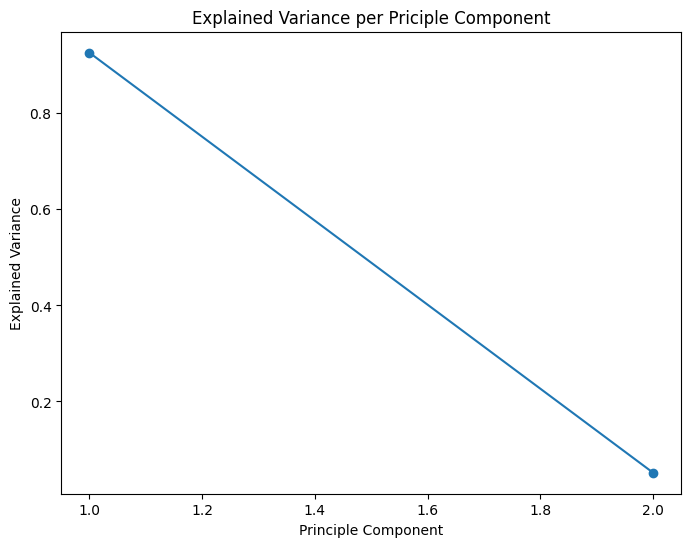

In [183]:
pca = PCA(n_components=2) # the elbow method showed 2 PC are best
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance per Priciple Component')
plt.xlabel('Principle Component')
plt.ylabel('Explained Variance')
plt.show()

# Clustering

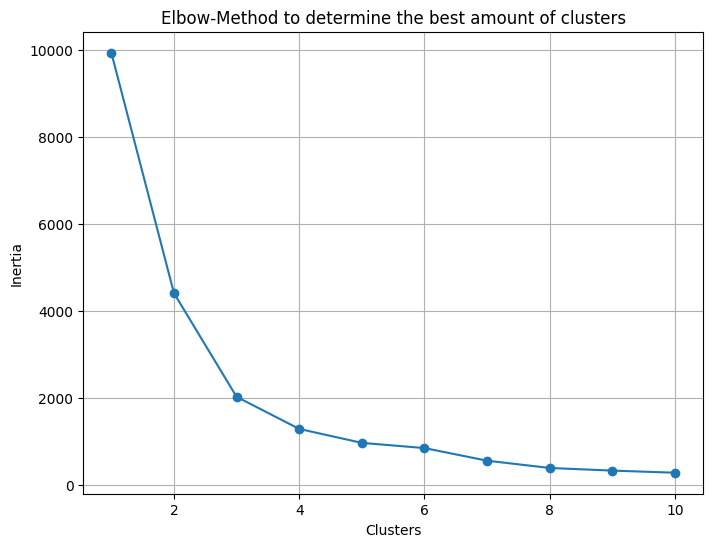

In [184]:
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Elbow-Method to visualize
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow-Method to determine the best amount of clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


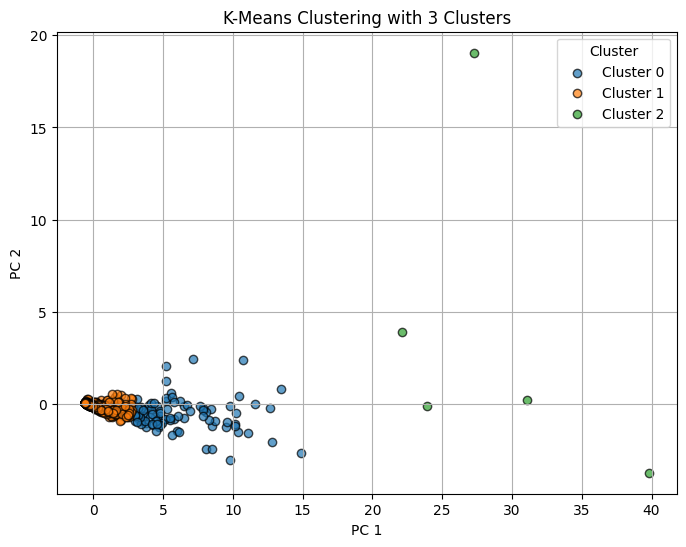

In [197]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df_final['cluster'] = clusters

plt.figure(figsize=(8, 6))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_pca[clusters == cluster_label, 0],
        X_pca[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        edgecolors='k'
    )

plt.title('K-Means Clustering with 3 Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [198]:
# 3d plotting

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
# X_tsne_3d = tsne_3d.fit_transform(X_pca)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# for cluster_label in sorted(set(clusters)):
#     ax.scatter(
#         X_tsne_3d[clusters == cluster_label, 0],
#         X_tsne_3d[clusters == cluster_label, 1],
#         X_tsne_3d[clusters == cluster_label, 2],
#         label=f'Cluster {cluster_label}',
#         alpha=0.7
#     )

# ax.set_title('3D t-SNE Visualization of Clusters')
# ax.set_xlabel('t-SNE 1')
# ax.set_ylabel('t-SNE 2')
# ax.set_zlabel('t-SNE 3')

# ax.legend(title='Cluster')
# plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


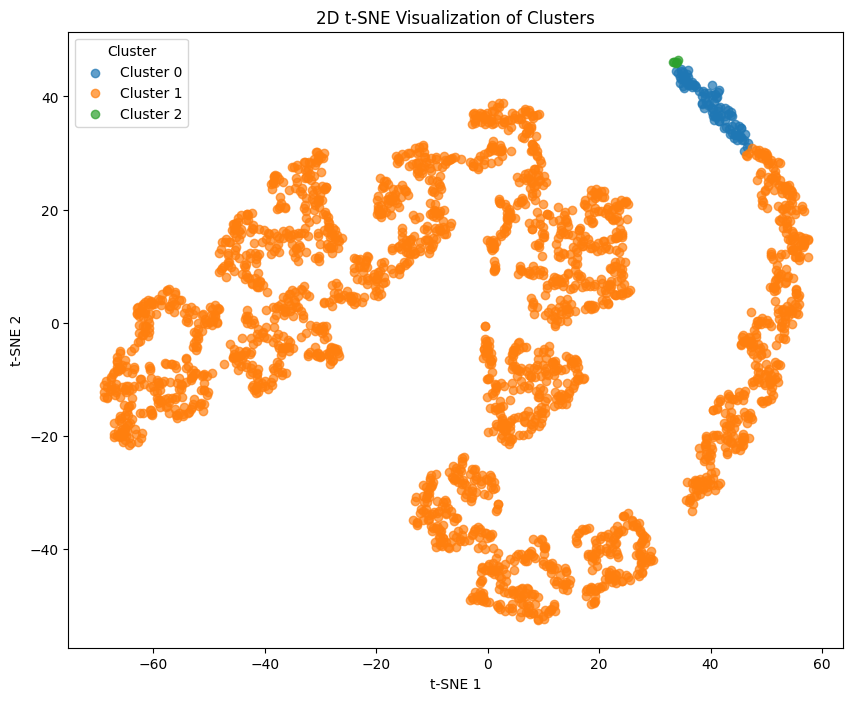

In [199]:
# 2d plotting
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_2d = tsne_2d.fit_transform(X_pca)

plt.figure(figsize=(10, 8))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_tsne_2d[clusters == cluster_label, 0],
        X_tsne_2d[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7
    )

plt.title('2D t-SNE Visualization of Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.show()


# Interpretation

In [219]:
df_final.head()

,FIPS,ap,est,emp,current_gdp,GDP_growth_rate,cluster
0,10001,2134610,4464,42526,22652836.0,2057.552230,1
1,10003,14906034,17494,243886,243477316.0,2962.917645,1
2,10005,3422794,6831,69693,43727204.0,2344.828798,1
4,11001,32310258,16705,390426,574989171.0,3328.926192,0
5,12001,4909957,7969,93572,64249411.0,3509.105676,1


In [220]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2543 entries, 0 to 2635
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FIPS             2543 non-null   object 
 1   ap               2543 non-null   int64  
 2   est              2543 non-null   int64  
 3   emp              2543 non-null   int64  
 4   current_gdp      2543 non-null   float64
 5   GDP_growth_rate  2543 non-null   float64
 6   cluster          2543 non-null   int32  
dtypes: float64(2), int32(1), int64(3), object(1)
memory usage: 149.0+ KB


In [230]:
cluster_summary = (
    df_final.groupby('cluster')
    .agg(
        count=('cluster', 'size'),
        avg_ap=('ap', 'mean'),
        avg_est=('est', 'mean'),
        avg_emp=('emp', 'mean'),
        avg_current_gdp=('current_gdp', 'mean')
    )
    .reset_index()
)

print(cluster_summary)

   cluster  count        avg_ap        avg_est       avg_emp  avg_current_gdp
0        0     94  3.726885e+07   32736.106383  5.658794e+05     3.457164e+08
1        1   2444  1.328716e+06    1795.170622  2.420463e+04     1.348694e+07
2        2      5  1.742635e+08  105257.200000  2.307235e+06     2.202755e+09


In [235]:
df_result = df_final[(df_final['cluster'] == 0) | (df_final['cluster'] == 2)].reset_index(drop=True)
df_result.head()

,FIPS,ap,est,emp,current_gdp,GDP_growth_rate,cluster
0,11001,32310258,16705,390426,574989171.0,3328.926192,0
1,12009,29801095,23332,369618,145310891.0,3523.941844,0
2,12011,53161981,73368,897929,588080980.0,3532.161925,0
3,12031,35875613,37163,614984,361484160.0,3621.954351,0
4,12057,55300445,56977,1015851,522828093.0,3581.524479,0


# Visalization

In [237]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Merging GeoData with clusters
gdf_cluster = df_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')
gdf_cluster = gdf_cluster.groupby('FIPS').agg({
    'emp': 'sum',
    'est': 'sum',
    'current_gdp': 'sum'
}).sort_values(['emp',	'est',	'current_gdp'])
gdf_cluster.head()

scaled_values = scaler.fit_transform(gdf_cluster[['emp', 'est', 'current_gdp']])

gdf_cluster['scaled_emp'] = scaled_values[:, 0]
gdf_cluster['scaled_est'] = scaled_values[:, 1]
gdf_cluster['scaled_gdp'] = scaled_values[:, 2]

gdf_cluster['economic_importance'] = (
    gdf_cluster['scaled_emp'] * 0.5 +
    gdf_cluster['scaled_est'] * 0.3 +
    gdf_cluster['scaled_gdp'] * 0.2
)

gdf_cluster = gdf_cluster.sort_values(by='economic_importance', ascending=False)

gdf_cluster.head()

,emp,est,current_gdp,scaled_emp,scaled_est,scaled_gdp,economic_importance
FIPS,,,,,,,
48201,3788109,149617,1.955070e+09,1.000000,0.991049,0.498690,0.897053
17031,2447409,150829,1.998678e+09,0.621133,1.000000,0.510459,0.712658
48113,2338111,85915,1.449368e+09,0.590247,0.520569,0.362212,0.523737
36061,1367631,57097,3.812610e+09,0.316000,0.307730,1.000000,0.450319
53033,1594913,82828,1.798052e+09,0.380228,0.497770,0.456314,0.430708


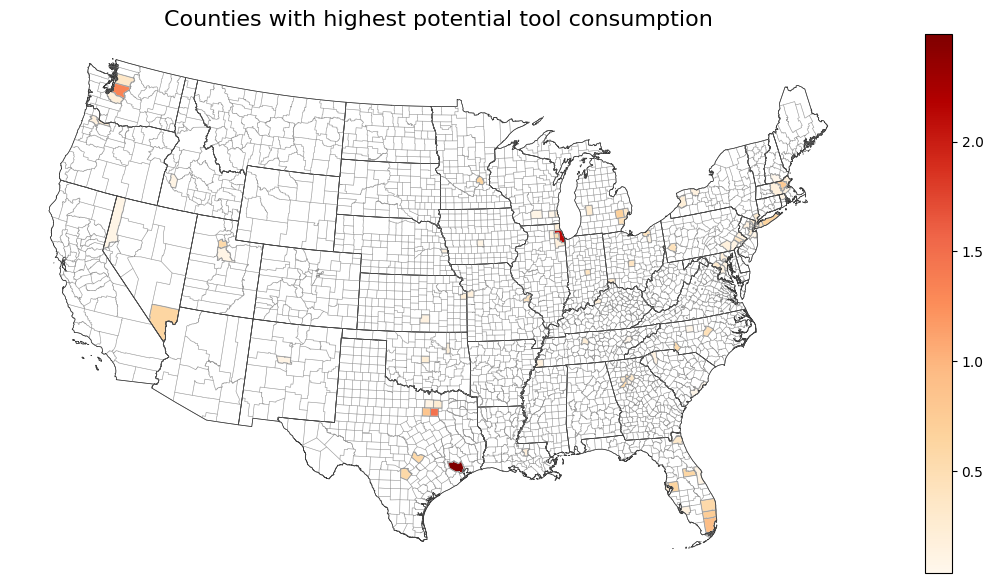

In [238]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

scaler = MinMaxScaler()
gdf_cluster['economic_importance'] = scaler.fit_transform(
    gdf_cluster[['emp', 'est', 'current_gdp']]
).sum(axis=1)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

fig, ax = plt.subplots(figsize=(15, 7))

vmin = gdf_cluster['economic_importance'].min()
vmax = gdf_cluster['economic_importance'].max()

gdf_cluster.plot(
    column='economic_importance',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    vmin=vmin,
    vmax=vmax
)

filtered_states.boundary.plot(ax=ax, color='black', linewidth=0.5)
filtered_county.boundary.plot(ax=ax, color='gray', linewidth=0.4, alpha=0.5)

ax.set_title('Counties with highest potential tool consumption', fontsize=16)
ax.set_axis_off()

plt.show()


In [239]:
gdf_cluster.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,FIPS,ap,est,emp,current_gdp,GDP_growth_rate,cluster,economic_importance
0,17,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((638438.26 2106115.85, 638973.311 210...",17197,26479513,25298,488665,174458426.0,2672.878216,0,0.158630
1,11,001,01702382,0500000US11001,11001,District of Columbia,00,158340391,18687198,"POLYGON ((1610776.964 1928085.948, 1611258.938...",11001,32310258,16705,390426,574989171.0,3328.926192,0,0.175499
2,12,009,00295749,0500000US12009,12009,Brevard,06,2629306677,1403367455,"POLYGON ((1465134.065 731674.673, 1465380.656 ...",12009,29801095,23332,369618,145310891.0,3523.941844,0,0.102602
3,12,095,00295750,0500000US12095,12095,Orange,06,2337566033,260717886,"POLYGON ((1397566.379 738382.739, 1397732.796 ...",12095,57499328,56137,901777,551076697.0,3670.704215,0,0.604777
4,13,121,01694833,0500000US13121,13121,Fulton,06,1364248547,19674940,"POLYGON ((1026472.2 1220877.734, 1026912.936 1...",13121,63005267,38401,857581,944737533.0,3519.674820,0,0.567537


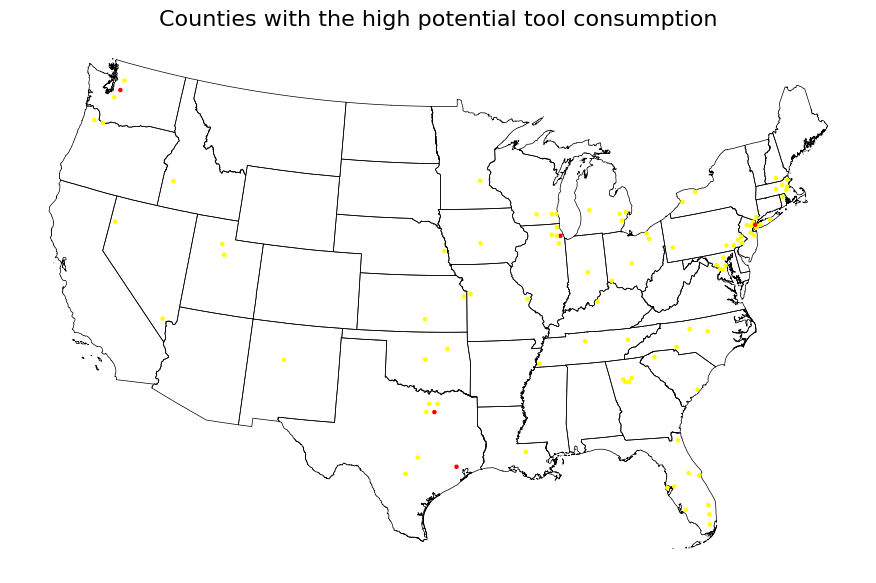

In [240]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

# Exclude some states
non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]

filtered_statefps = filtered_states['STATEFP'].unique()

filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

gdf_cluster['centroid'] = gdf_cluster.geometry.centroid

# Farben basierend auf dem Cluster
colors = gdf_cluster['cluster'].map({0: 'yellow', 2: 'red'})

fig, ax = plt.subplots(figsize=(15, 7))

# Hintergrund mit Staaten
filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

# Cluster mit Farben visualisieren
gdf_cluster.set_geometry('centroid').plot(ax=ax, color=colors, markersize=5)

ax.set_title('Counties with the high potential tool consumption', fontsize=16)
ax.set_axis_off()

plt.show()


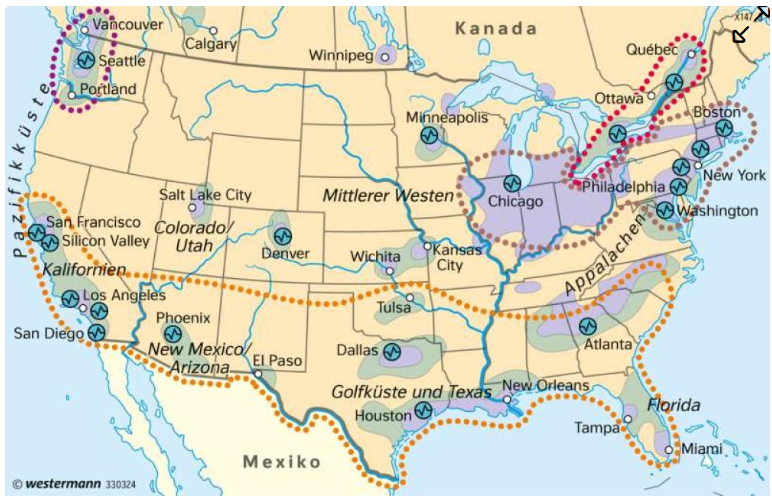

In [241]:
import cv2
from google.colab.patches import cv2_imshow

image_path = '/content/DDM-Project-WS24-25/usa_economic_key_regions.png'
image = cv2.imread(image_path)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

- The Manufacturing Belt around Chicago and Detroit is the largest and oldest industrial region in the U.S., recently impacted by significant structural change.

- The East Coast metropolitan area, from Boston through New York to Washington, is a leading hub for high-tech industries, diverse manufacturing, and major service centers.

- The Portland/Seattle area is known for strong high-tech and aerospace industries, alongside timber processing and paper manufacturing.

- Economic centers in the West include San Francisco and the Silicon Valley (electronics and computer industries) as well as Los Angeles/San Diego (high-tech, heavy and light industries, and services). Together with mining, industrial, high-tech, and service hubs in Phoenix, Dallas, Houston/New Orleans, Atlanta, and Florida, these regions form the Sunbelt, the U.S. economy's growth area.